# Lab 5: Image Classification in Pytorch - Convnets [CIFAR-10]
 **See handout-06:** https://frcs.github.io/4C16-LectureNotes/

Similarly to lab 4, you will train a Neural Network to do classification on CIFAR-10.

This time you will have to use convolutional layers.

the aim of this lab is for you to:
1. become familiar with PyTorch
2. experiment with as many concepts as possible.




## Note: Enabling GPU  

By default, Colab runs CPU only. To change to GPU mode, go to Runtime>Change runtime type, select "hardware accelerator" to GPU.

This will restart your instance (obviously), so everytime you do this you'll need to start your again from the start of the notebook.

Beware that GPU instances are not always available. Also, Google might restrict your usage. Google doesn't have clear rules on this.

So be mindful and **only use GPU instances for training. Use CPU only for development and tinkering.**





In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/4c16-labs/code/lab-05/

# 1. Import Required Libraries

In [ ]:
import os
import pickle                                     # Used for unpacking our imported python dataset
import importlib
import urllib.request                             # Used for fetching data from URLs
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
import numpy as np
from tqdm.auto import tqdm                        # Used for progress bars
import sklearn.model_selection                    # Helper function for splitting datasets
from IPython.display import clear_output

import torch                                      # The main PyTorch library
import torch.nn as nn                             # Contains pytorch network building blocks (e.g., layers)
import torch.nn.functional as F                   # Contains functions for neural network operations (e.g., activation functions)
from torch.utils.data import Dataset, DataLoader  # Utilities for datasets and data loaders
from torchsummary import summary                  # Used for printing PyTorch model summary

# 2. Loading the Dataset

To load the dataset, the standard practice is to create a `Dataset` class.

In [ ]:
class CIFAR10Dataset(Dataset):
    """Custom CIFAR-10 dataset from provided pickle file.
    Handles download (if missing), train/val split, normalization, tensor conversion.
    """
    def __init__(self, url, pkl_path, train=True, test_size=0.1, random_state=42):
        super().__init__()
        data_dir = os.path.dirname(pkl_path)
        os.makedirs(data_dir, exist_ok=True)
        if not os.path.exists(pkl_path):
            print(f'Downloading dataset to {pkl_path} ...')

            urllib.request.urlretrieve(url, pkl_path)
            print('Download complete.')
        print('Loading dataset...')
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
        print('Loaded.')
        # loading the input images
        # images are rescaled from 0..255 to 0..1
        X = data['X'].astype('float32') / 255.0
        # loading the Ground Truth classes
        Y = data['Y'].astype('int64')
        if Y.ndim > 1:  # ensure labels are 1D
            Y = np.squeeze(Y)
        self.labels = data['labels']
        self.num_classes = len(self.labels)
        # random split of the data into training set and validation set
        X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
            X, Y, test_size=test_size, random_state=random_state
        )
        # casting numpy data to torch data
        if train:
            self.X = torch.from_numpy(X_train)
            self.y = torch.from_numpy(y_train)
        else:
            self.X = torch.from_numpy(X_val)
            self.y = torch.from_numpy(y_val)
        self.y = self.y.long().view(-1)
        # permuting dimensions to PyTorch conventions (N,C,H,W)
        self.X = self.X.permute(0, 3, 1, 2)
        self.len = self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    def __len__(self):
        return self.len

# 3. Instantiate the training and validation dataset classes

In [ ]:
# Path to the classification dataset
datset_url = 'https://tcddeeplearning.blob.core.windows.net/deeplearning202324/cifar10-dataset.pkl'
# Path to your lab 4 Drive directory on the Colab VM
lab_5_dir = '/home/tcd/Downloads/cifar10-dataset.pkl'

trainset = CIFAR10Dataset(datset_url, lab_5_dir, train=True)
valset = CIFAR10Dataset(datset_url, lab_5_dir, train=False)
print('Train size:', len(trainset), ' Val size:', len(valset))


# 4. Visualize Sample Images

In [ ]:
plt.figure(figsize=(6,4))
for i in range(24):
    img, lab = trainset[i]
    plt.subplot(4,6,i+1)
    plt.imshow(img.permute(1,2,0))
    plt.axis('off')
    plt.title(trainset.labels[lab])
plt.tight_layout()
plt.show()


# same as in lab 4

# 5. Now, go to `models.py` and define your own CNN model here

You will define your own Convolutional Neural Network model using PyTorch's `nn.Module`.

For a comprehensive list of PyTorch building blocks, see: https://docs.pytorch.org/docs/stable/nn.html



In [ ]:
# Note that the new model is called ConvNN and not SimpleNN as in lab 4

from models import ConvNN

# 6. Check your model shape and size

The model must not exceed 5M trainable parameters.


In [ ]:
# device refers to the GPU or the CPU, depending whether GPU is available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Call our model. The number of output classes is passed as an argument.
# Re-import the ConvNN
# We need to always re-import the ConvNN after importlib reload as autoreload do not work in Google Colab as per https://github.com/googlecolab/colabtools/issues/5580.
# If you work without Google Colab, you will not need this.
importlib.reload(models)
from models import ConvNN

model = ConvNN(num_classes=trainset.num_classes).to(device)

# display information about the model
summary(model, (3,32,32))

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Trainable parameters:', params)
if params > 5_000_000:
    raise Exception('Your model is unecessarily complex, scale down!')

# 7.  Monitoring


Don't edit this cell 😺

In [ ]:
# Custom callback for plotting loss and accuracy during training

class PlotLogAccuracy:

  def __init__(self):
    self.epochs = []
    self.train_losses = []
    self.val_losses = []
    self.train_acc = []
    self.val_acc = []
    self.epoch_count = 0

  def update(self, train_loss, train_acc, val_loss, val_acc):
    self.epochs.append(self.epoch_count)
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_count += 1

    clear_output(wait=True)
    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    plt.plot(self.epochs, self.train_losses, label="train loss")
    plt.plot(self.epochs, self.val_losses, label="validation loss")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Model Loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(self.epochs, self.train_acc, label="training accuracy")
    plt.plot(self.epochs, self.val_acc, label="validation accuracy")
    plt.legend()
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('Model Accuracy')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show();

# 8. Optimiser and Dataloader Hyperparameter Setup

Here we define the dataloaders which handle the dataset, and the training optimiser.

Their hyperparameters include (but are not limited to):


*   Number of training epochs
*   Batch size
* Learning rate (step size)
* Optimiser momentum
* Dataset shuffling

Remember from class that the optimiser sets the weights and biases of the network during training. [Many exist](https://docs.pytorch.org/docs/stable/optim.html).


In [28]:
epochs = 100           # shorter for notebook demo - increase for training
batch_size = 64       # play with this
learning_rate = 0.01  # play with this
momentum = 0.9        # play with this

criterion = nn.CrossEntropyLoss()

# Reload ConvNN
importlib.reload(models)
from models import ConvNN

# setting the model (calling this again will reset the weights)
model = ConvNN(num_classes=trainset.num_classes).to(device)

# play with this
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True,
                         num_workers=0, pin_memory=torch.cuda.is_available())
valloader   = DataLoader(valset, batch_size=batch_size, shuffle=False,
                         num_workers=0, pin_memory=torch.cuda.is_available())

plotter = PlotLogAccuracy()

train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

print('Setup complete.')

Setup complete.


# 9. Training and Validation

The following cell contains the main training and validation loop for the neural network.



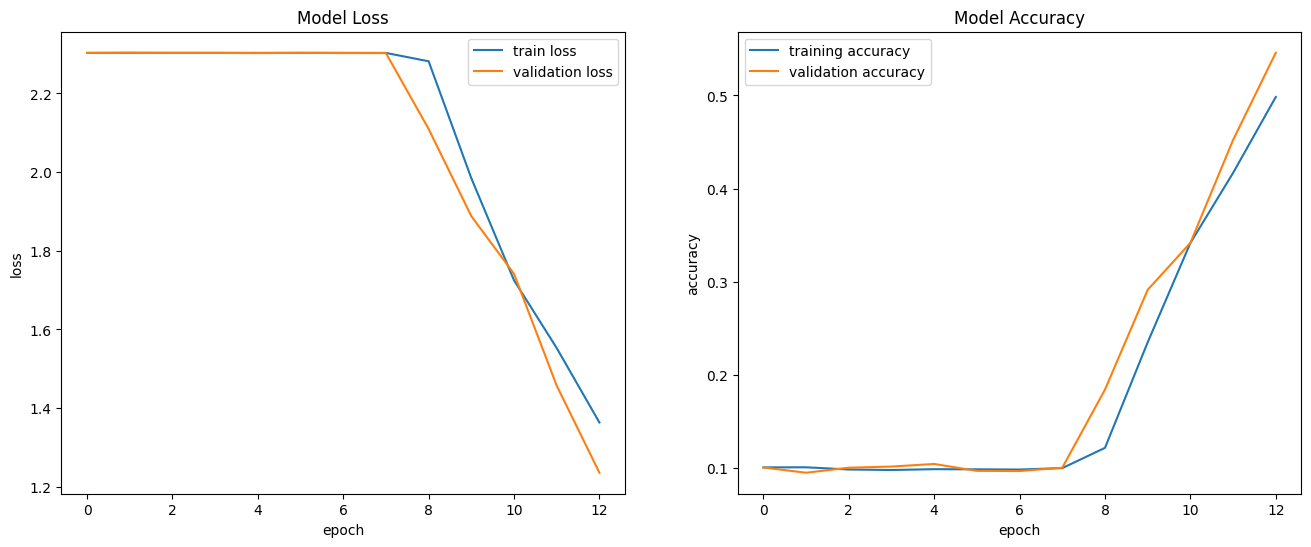

Epoch 13: Train Loss 1.3636 Acc 0.4983 | Val Loss 1.2359 Acc 0.5458


Epoch 14/100 [Train]:   0%|          | 0/704 [00:00<?, ?it/s]

In [ ]:
print('Starting training...')

# Epoch Loop: It iterates through the specified number of training epochs.

for epoch in range(epochs):

    # For each epoch, all data in the dataset is processed.

    model.train() # Sets the model to training mode

    running_loss, correct, total = 0.0, 0, 0 # resetting loss/accuracy metrics

    #  Iterates through the `trainloader` to get mini-batches of data
    for x_batch, y_batch in tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs} [Train]', leave=False):

        # copying data to the GPU (the `device`) if GPU is available
        x_batch, y_batch = x_batch.to(device), y_batch.to(device).view(-1)

        optimizer.zero_grad()           # setting up gradient to zero
        out = model(x_batch)            # Performs the forward pass
        loss = criterion(out, y_batch)  # calculates the loss
        loss.backward()                 # performs backpropagation in parallel on the batch
        optimizer.step()                # optimizer steps to update the model's weights

        # updating current training Loss and Accuracy on the mini-batch
        running_loss += loss.item() * x_batch.size(0)
        preds = out.argmax(1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()

    train_loss = running_loss / len(trainloader.dataset)
    train_acc = correct / total

    # Computing Validation Loss and Accuracy

    model.eval() # switching model to eval mode, disabling dropout/batchnorm/other custom modules
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad(): # we disable gradient computation to save some memory
        for x_batch, y_batch in tqdm(valloader, desc=f'Epoch {epoch+1}/{epochs} [Val]', leave=False):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device).view(-1)
            out = model(x_batch)
            loss = criterion(out, y_batch)
            val_running_loss += loss.item() * x_batch.size(0)
            preds = out.argmax(1)
            val_total += y_batch.size(0)
            val_correct += (preds == y_batch).sum().item()
    val_loss = val_running_loss / len(valloader.dataset)
    val_acc = val_correct / val_total

    # Record training loss and accuracy
    train_loss_hist.append(train_loss); val_loss_hist.append(val_loss)
    train_acc_hist.append(train_acc); val_acc_hist.append(val_acc)

    # At the end of the epoch, plot loss and accuracy for training/validation
    plotter.update(train_loss, train_acc, val_loss, val_acc)
    print(f'Epoch {epoch+1}: Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f}')

print('Training finished.')


# 10. Save your model to your lab 5 directory.

In [25]:
MODEL_PATH = 'model.pth'  # DO NOT CHANGE THE NAME, this is required by the evaluation script

# Save the entire model
torch.save(model, os.path.join('/content/gdrive/MyDrive/4c16-labs/code/lab-05', MODEL_PATH))
print('Model saved to', MODEL_PATH)


Model saved to model.pth


# 11. Load and test your model

Note: we will evaluate your model on a different dataset. This cell is to demonstrate model loading and give you a rough idea of your model performance.


In [ ]:
loaded = torch.load(MODEL_PATH, map_location=device, weights_only=False)
loaded.eval()
val_loss_sum, val_correct, val_total = 0.0, 0, 0
with torch.no_grad():
    for x_batch, y_batch in valloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device).view(-1)
        out = loaded(x_batch)
        loss = criterion(out, y_batch)
        val_loss_sum += loss.item() * x_batch.size(0)
        preds = out.argmax(1)
        val_total += y_batch.size(0)
        val_correct += (preds == y_batch).sum().item()
final_val_loss = val_loss_sum / len(valloader.dataset)
final_val_acc = val_correct / val_total
print(f'Reloaded Model - Val Loss: {final_val_loss:.4f}, Val Acc: {final_val_acc:.4f}')

# Lab objective: get 80% accuracy